<a href="https://colab.research.google.com/github/matteo-cutroni/CV-project/blob/main/Efficient_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from torchvision.utils import make_grid


cpu


# Hyperparameters

In [2]:
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 128          # Size of the generator's input noise vector
G_LR = 1e-4          # Learning rate for Generator
D_LR = 1e-4          # Learning rate for Discriminator
NUM_EPOCHS = 100

# Utils

In [3]:
def show_images(images):
    # reverse the normalization
    images = images * 0.5 + 0.5
    img_grid = make_grid(images, nrow=8)
    img_grid_np = img_grid.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid_np)
    plt.axis('off')
    plt.show()

# Dataset

In [4]:
# resize to 64x64 and normalize in range [-1.0, 1.0]
transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(CHANNELS_IMG)],
        [0.5 for _ in range(CHANNELS_IMG)]
    )
])

dataset = datasets.CIFAR10(
    root="dataset/",
    train=True,
    transform=transforms,
    download=True
)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2 # num_workers=2 is recommended by Colab
)

100%|██████████| 170M/170M [00:02<00:00, 62.4MB/s]


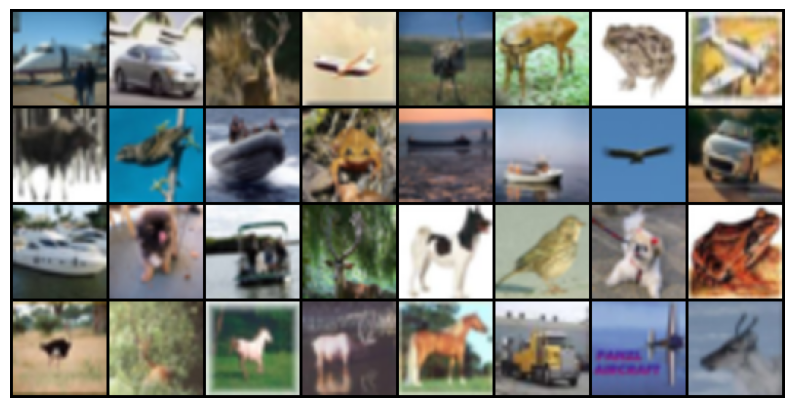

In [6]:
real_batch = next(iter(dataloader))
images, labels = real_batch

show_images(images[:32])